# Program za določitev višine kapljevinskega stolpca

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL.Image as Image
import pyautogui
import scipy.constants as const
import CoolProp.CoolProp as CP

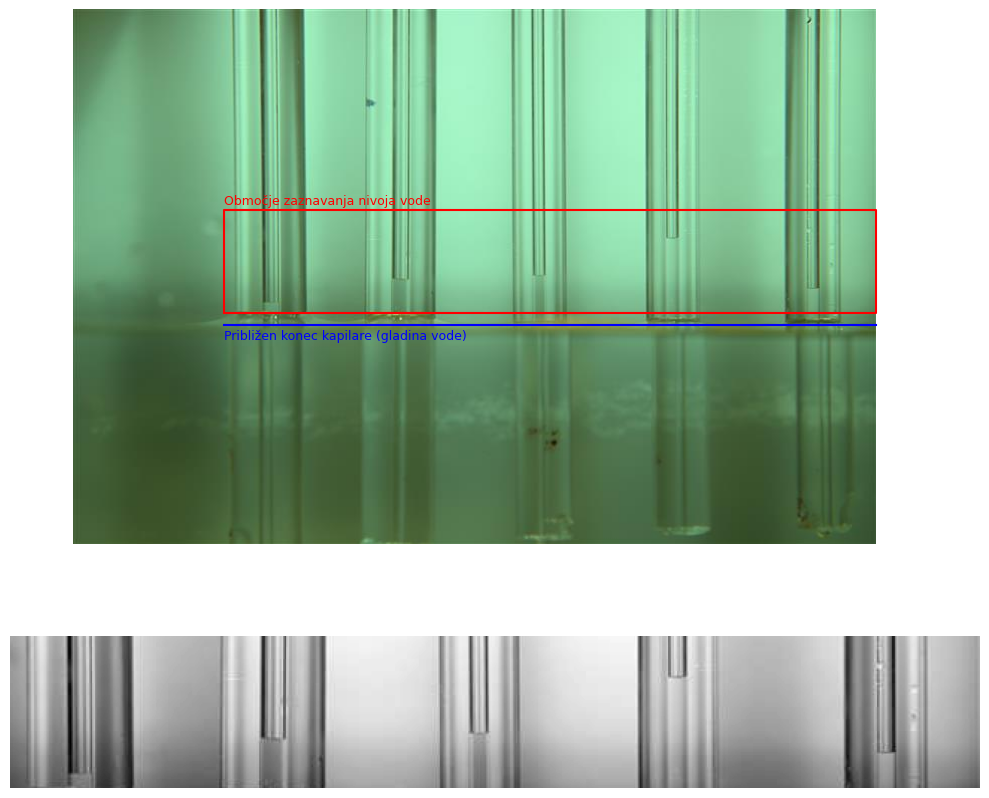

In [21]:
img_or = cv2.cvtColor(cv2.imread(r"SK2_23-10-2025.JPG"), cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(cv2.imread(r"SK2_23-10-2025.JPG"), cv2.COLOR_BGR2RGB)
canal_diam = 8 #mm
heigth_plus = 12 #px
T_ok = 22 #°C
rho_w = CP.PropsSI("D", "T", T_ok + 273.15, "P", 101325, "Water")   # [kg/m³]
rho_a = CP.PropsSI("D", "T", T_ok + 273.15, "P", 101325, "Air")   # [kg/m³]
sigma_w  = CP.PropsSI("I", "T", T_ok + 273.15, "D", 1, "Water")   # [Pa·s]

x_left = 150
x_right = 800
y_top = 200
y_bottom = 302
img = img_or[y_top:y_bottom, x_left:x_right]
img_h, img_w = img.shape
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(img_rgb)
plt.text(x_left, y_top - 6, "Območje zaznavanja nivoja vode", fontsize=9, color="red")
plt.plot([x_left, x_right, x_right, x_left, x_left], [y_bottom, y_bottom, y_top, y_top, y_bottom], c="red")
plt.text(x_left, y_bottom + heigth_plus + 15, "Približen konec kapilare (gladina vode)", fontsize=9, color="blue")
plt.plot([x_left, x_right], [y_bottom + heigth_plus, y_bottom + heigth_plus], c="blue")
plt.axis("off")
plt.subplot(2,1,2)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

In [4]:
sobel_x = cv2.Sobel(img, cv2.CV_64F, dx=1, dy=0, ksize=1)
sobel_x = cv2.convertScaleAbs(sobel_x)
edges_x = cv2.Canny(sobel_x, 50 , 100)
y_coords, x_coords = np.where(edges_x > 0)
edge_points = np.column_stack((x_coords, y_coords))
edge_points = edge_points[edge_points[:, 0].argsort()] #sort by x


grouped_points = []
current_group = []
range_width = 100 #Group points range

if len(edge_points) > 0:
    current_group.append(edge_points[0])
    group_start_x = edge_points[0][0]

    for point in edge_points[1:]:
        x, y = point
        if x - group_start_x <= range_width:
            current_group.append(point)
        else:
            grouped_points.append(current_group)
            current_group = [point]
            group_start_x = x

    grouped_points.append(current_group)

last_point = [group[-1][0] for group in grouped_points]
first_point = [group[0][0] for group in grouped_points]

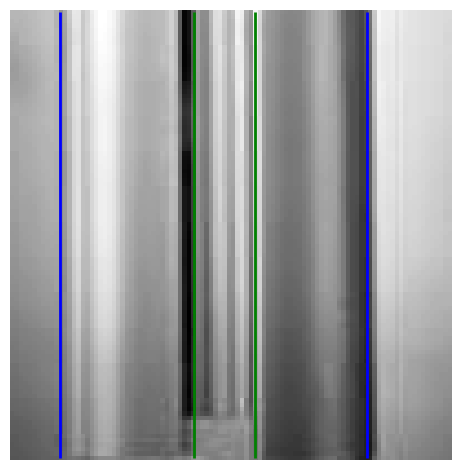

Meassured diameter in px: 69.431 px,
Meassured diameter in mm: 8.0 mm,
Meassured capillary diameter in mm: 1.602 mm
mm/px ratio: 0.115


In [5]:

left = 0
right = 100
img_cap = img[:,left:right]
sobel_x = cv2.Sobel(img_cap, cv2.CV_64F, dx=1, dy=0, ksize=1)
sobel_x = cv2.convertScaleAbs(sobel_x)
edges_x = cv2.Canny(sobel_x, 50 , 110)
y_coords, x_coords = np.where(edges_x > 0)
edge_points = np.column_stack((x_coords, y_coords))
edge_points = edge_points[edge_points[:, 0].argsort()] #sort by x

grouped_points = []
current_group = []
range_width = 10 #Group points range

if len(edge_points) > 0:
    current_group.append(edge_points[0])
    group_start_x = edge_points[0][0]

    for point in edge_points[1:]:
        x, y = point
        if x - group_start_x <= range_width:
            current_group.append(point)
        else:
            grouped_points.append(current_group)
            current_group = [point]
            group_start_x = x

    grouped_points.append(current_group)


start = np.mean(np.array(grouped_points[0])[:, 0])
end = np.mean(np.array(grouped_points[-1])[:, 0])
d_px = end - start

m = len(grouped_points)/2

m_l = int(m-0.5)
m_r = int(m+0.5)

start_cap = np.mean(np.array(grouped_points[m_l])[:, 0])
end_cap = np.mean(np.array(grouped_points[m_r])[:, 0])

d_cap_px = end_cap - start_cap

if start == start_cap or end == end_cap:
    raise Exception("Check Canny thresholds or group points number, edges are not detecting properly.")

plt.imshow(img_cap, cmap="gray")
plt.vlines([start, end], [0,0],[img_h-1, img_h-1], colors="blue", lw=2)
plt.vlines([start_cap, end_cap], [0,0],[img_h-1, img_h-1], colors="green", lw=2)
#plt.scatter(x_coords, y_coords, color="red", s=1)
plt.axis("off")
plt.tight_layout()
plt.show()

mm_px_ratio = canal_diam/d_px

d_cap_mm = d_cap_px * mm_px_ratio
d_mm = d_px * mm_px_ratio

print(f"Meassured diameter in px: {np.round(d_px, 3)} px,")
print(f"Meassured diameter in mm: {np.round(d_mm, 3)} mm,")
print(f"Meassured capillary diameter in mm: {np.round(d_cap_mm, 3)} mm")
print(f"mm/px ratio: {np.round(mm_px_ratio, 3)}")

Group 1: 16 points, X px range ~ 39-45
Group 2: 16 points, X px range ~ 168-185
Group 3: 18 points, X px range ~ 307-320
Group 4: 30 points, X px range ~ 441-453
Group 5: 18 points, X px range ~ 584-592


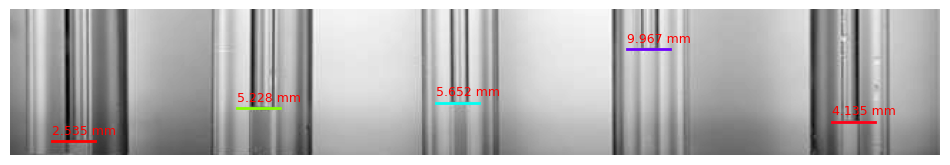

Heigth for group 1 in px: 22.0 px
Heigth for group 2 in px: 45.375 px
Heigth for group 3 in px: 49.056 px
Heigth for group 4 in px: 86.5 px
Heigth for group 5 in px: 35.889 px
#------------------------------------#
Heigth for group 1 in mm: 2.535 mm
Heigth for group 2 in mm: 5.228 mm
Heigth for group 3 in mm: 5.652 mm
Heigth for group 4 in mm: 9.967 mm
Heigth for group 5 in mm: 4.135 mm


In [6]:
sobel_y = cv2.Sobel(img, cv2.CV_64F, dx=0, dy=1, ksize=1)
sobel_y = cv2.convertScaleAbs(sobel_y)
edges = cv2.Canny(sobel_y, 80 , 190)

y_coords, x_coords = np.where(edges > 0)
edge_points = np.column_stack((x_coords, y_coords))
edge_points = edge_points[edge_points[:, 0].argsort()] #sort by x

grouped_points = []
current_group = []
range_width = 30 #Group points range

if len(edge_points) > 0:
    current_group.append(edge_points[0])
    group_start_x = edge_points[0][0]

    for point in edge_points[1:]:
        x, y = point
        if x - group_start_x <= range_width:
            current_group.append(point)
        else:
            grouped_points.append(current_group)
            current_group = [point]
            group_start_x = x

    grouped_points.append(current_group)

for i, group in enumerate(grouped_points):
    print(f"Group {i+1}: {len(group)} points, X px range ~ {group[0][0]}-{group[-1][0]}")


plt.figure(figsize=(12, 6))
plt.imshow(img, cmap="gray")

colors = plt.get_cmap('hsv', len(grouped_points))
line_length = 30  

y_px = []
y_group_px = {}
y_group_mm = {}
for i, group in enumerate(grouped_points):
    group = np.array(group)
    x_vals = group[:, 0]
    y_vals = group[:, 1]

    x_start = x_vals.min() - 10
    x_end = x_start + line_length
    y_mean = np.mean(y_vals)
    y_px.append(y_mean)
    y_mean_1 = (img_h - np.mean(y_vals)) + heigth_plus
    y_group_px.update({i : y_mean_1})
    y_group_mm.update({i : y_mean_1 * mm_px_ratio})
    plt.text(x_start, y_mean - 5, f"{np.round(y_mean_1 * mm_px_ratio, 3)} mm", fontsize=9, color="red")
    plt.plot([x_start, x_end], [y_mean, y_mean], color=colors(i), linewidth=2)

plt.axis("off")
plt.show()

for i, group in enumerate(grouped_points):
    print(f"Heigth for group {i+1} in px: {np.round(y_group_px[i], 3)} px")

print("#------------------------------------#")

for i, group in enumerate(grouped_points):
    print(f"Heigth for group {i+1} in mm: {np.round(y_group_mm[i], 3)} mm")

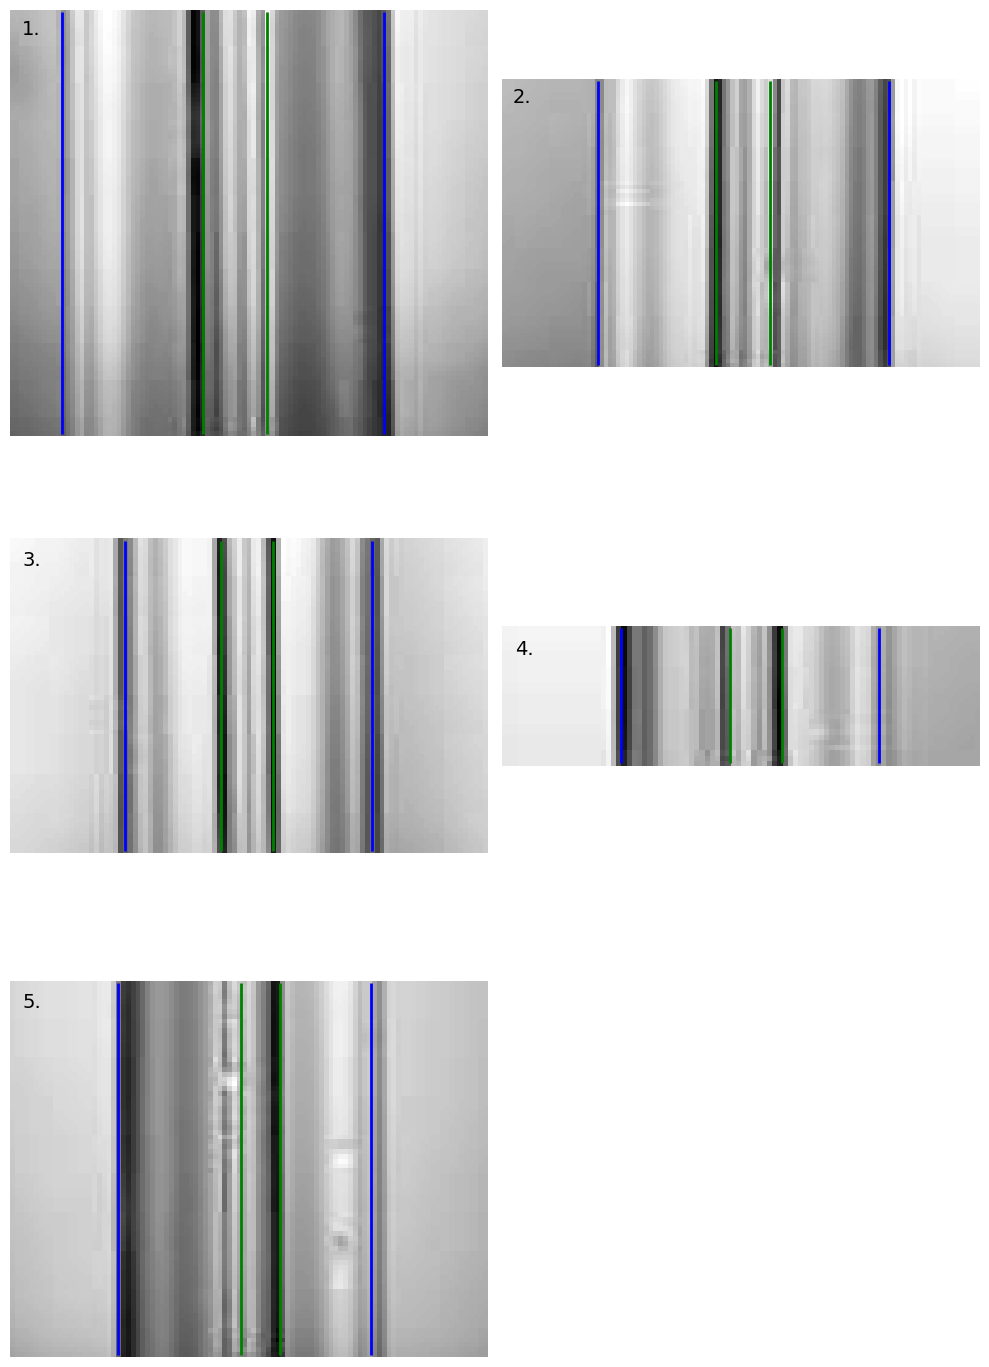

Meassured diameters in px: [69.492 68.971 50.165 49.667 52.461] px,
Meassured diameters in mm: [8.007 7.947 5.78  5.723 6.045] mm,
Meassured capillary diameters in mm: [1.571 1.482 1.219 1.154 0.919] mm
mm/px ratio: 0.115


In [7]:
d_px = []
d_cap_px = []
it = 0
plt.figure(figsize=(10, 15))
for i in range(len(last_point)):
    it +=1
    left = max(first_point[i] - 20, 0)
    right = min(last_point[i]+20, img_w)
    bottom = int(y_px[i])
    img_cap = img[:bottom,left:right]
    sobel_x = cv2.Sobel(img_cap, cv2.CV_64F, dx=1, dy=0, ksize=1)
    sobel_x = cv2.convertScaleAbs(sobel_x)
    edges_x = cv2.Canny(sobel_x, 50 , 110)
    y_coords, x_coords = np.where(edges_x > 0)
    edge_points = np.column_stack((x_coords, y_coords))
    edge_points = edge_points[edge_points[:, 0].argsort()] #sort by x

    grouped_points = []
    current_group = []
    range_width = 10 #Group points range

    if len(edge_points) > 0:
        current_group.append(edge_points[0])
        group_start_x = edge_points[0][0]

        for point in edge_points[1:]:
            x, y = point
            if x - group_start_x <= range_width:
                current_group.append(point)
            else:
                grouped_points.append(current_group)
                current_group = [point]
                group_start_x = x

        grouped_points.append(current_group)


    start = np.mean(np.array(grouped_points[0])[:, 0])
    end = np.mean(np.array(grouped_points[-1])[:, 0])
    d = end - start

    d_px.append(d)

    m = len(grouped_points)/2

    m_l = int(m-0.5)
    m_r = int(m+0.5)

    start_cap = np.mean(np.array(grouped_points[m_l])[:, 0])
    end_cap = np.mean(np.array(grouped_points[m_r])[:, 0])

    d_cap_px.append(end_cap - start_cap)

    if start == start_cap or end == end_cap:
        raise Exception("Check Canny thresholds or group points number, edges are not detecting properly.")

    plt.subplot(int(np.ceil(len(last_point)/2)), 2, it)
    plt.imshow(img_cap, cmap="gray")
    plt.vlines([start, end], [0,0],[bottom-1, bottom-1], colors="blue", lw=2)
    plt.vlines([start_cap, end_cap], [0,0],[bottom-1, bottom-1], colors="green", lw=2)
    plt.text(2, 5, f"{it}.", fontsize=14, color="black")
    #plt.scatter(x_coords, y_coords, color="red", s=1)
    plt.axis("off")
plt.tight_layout()
plt.show()

d_cap_mm = np.array(d_cap_px) * mm_px_ratio
d_mm = np.array(d_px) * mm_px_ratio

print(f"Meassured diameters in px: {np.round(d_px, 3)} px,")
print(f"Meassured diameters in mm: {np.round(d_mm, 3)} mm,")
print(f"Meassured capillary diameters in mm: {np.round(d_cap_mm, 3)} mm")
print(f"mm/px ratio: {np.round(mm_px_ratio, 3)}")

In [ ]:
theta = [80, 86, 83, 84, 83]
theta_rad = np.deg2rad(np.array(theta))

In [ ]:
for i in range(len(theta)):
    th = theta_rad[i]
    H = y_group_mm[i] * 10**-3
    